<a href="https://colab.research.google.com/github/bohanl/fsdl-project/blob/master/cardinality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_log_error, explained_variance_score, max_error, mean_absolute_error

def plot_model_statistics(y_actual, y_pred):
    # Prepare data for comparison
    result_frame = pd.DataFrame({'Actual': y_actual, 'Pred': y_pred})

    print('Mean Log Error:      {}'.format(mean_squared_log_error(result_frame['Actual'], result_frame['Pred'])))
    print('Mean Absolute Error: {}'.format(mean_absolute_error(result_frame['Actual'], result_frame['Pred'])))
    print('Max Absolute Error:  {}'.format(max_error(result_frame['Actual'], result_frame['Pred'])))
    print('Score:               {}'.format(explained_variance_score(result_frame['Actual'], result_frame['Pred'])))

    plt.figure(figsize=(18,10))
    plt.xlabel('{} Cardinality Estimates'.format('Pred'))

    ax1 = result_frame['Actual'].plot(color='red', grid=True, label='Actual')
    ax2 = result_frame['Pred'].plot(color='green', grid=True, label='Pred')

    ax1.legend(loc=1)
    ax2.legend(loc=2)

    plt.show()

In [0]:
# Import dataset

# This dataset contains about 3500+ samples, where each sample has the following
# format:
# | 1,0,1,1,0,0,0,0, | 0.5875,0,0,0,0,0.0395,0,0,0,0,0 | MySQL Estimated | Actual |

import os

import pandas as pd

dataset = pd.read_csv('https://raw.githubusercontent.com/bohanl/fsdl-project/master/data/annotated_queries.csv', delimiter=",", header=None)
filtered_dataset = dataset.drop(dataset[dataset[20] == 0].index, axis=0, inplace=False)
annotated_queries = filtered_dataset.to_numpy().astype(np.float32)

In [0]:
# Train/Validation/Test Data Split
# 60/20/20

from sklearn.model_selection import train_test_split

X = annotated_queries[:,:19]  # first 19 columns (relations bit vector + columns value percentage)
y = annotated_queries[:,-2:]   # estimated and actual number of rows (cardinality)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

Mean Log Error:      1.1581525802612305
Mean Absolute Error: 84589.640625
Max Absolute Error:  3293921.0
Score:               0.5214955806732178


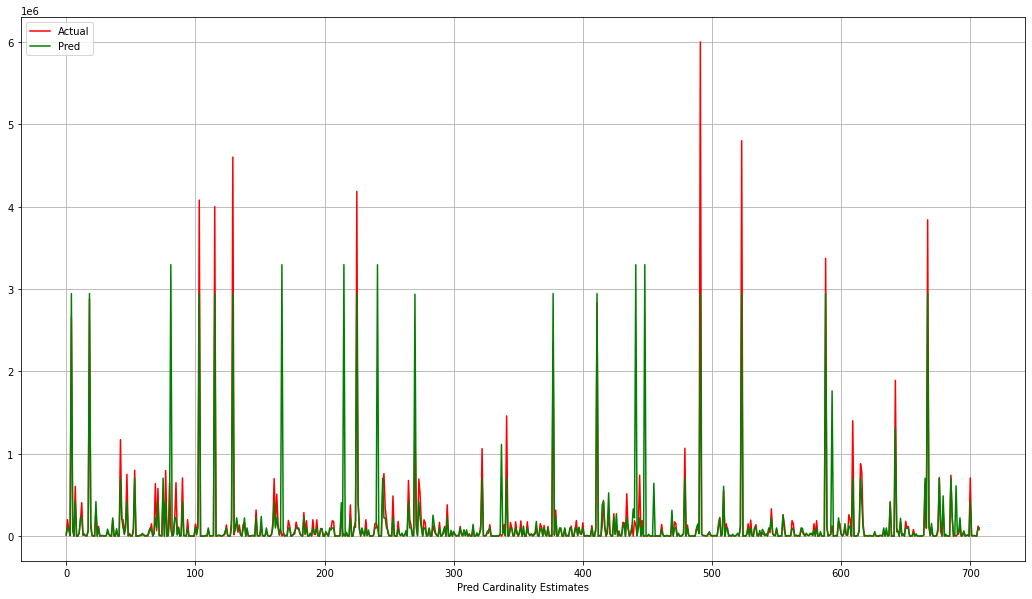

In [45]:
# ==============================================================================
#                MySQL Estimator
# ==============================================================================

plot_model_statistics(y_test[:,-1], y_test[:,-2])

Mean Log Error:      3.5912994464489874
Mean Absolute Error: 19205.558298577085
Max Absolute Error:  1399431.0
Score:               0.9620955351598943


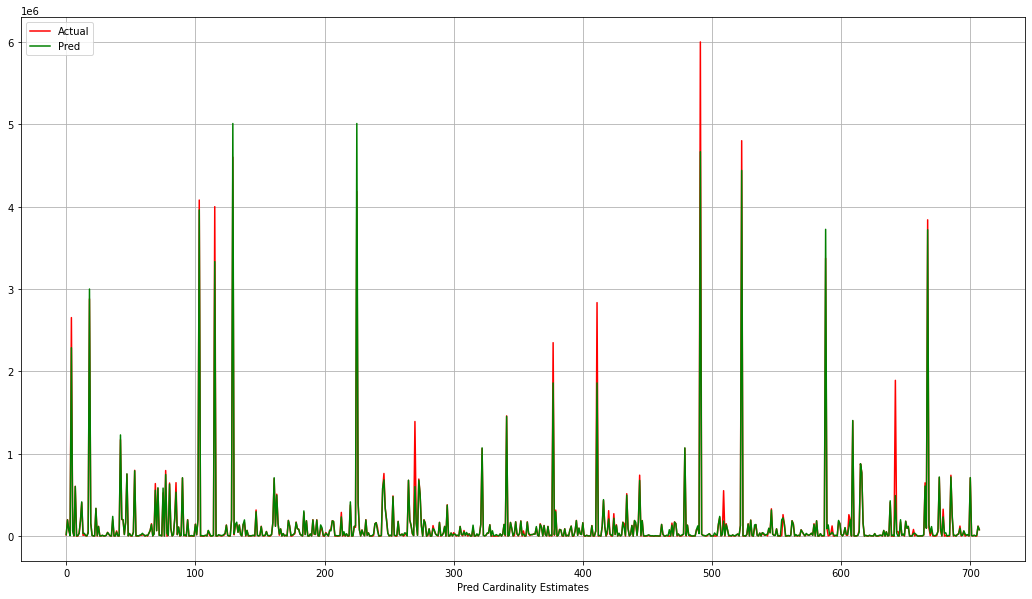

In [42]:
# ==============================================================================
#                Model 1: Emsemble of Decision Trees
# ==============================================================================

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# regressor = RandomForestRegressor(n_estimators=500, max_leaf_nodes=256, n_jobs=-1, bootstrap=True)
regressor = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_leaf_nodes=256,),
    n_estimators=500)

regressor.fit(X_train, y_train[:,-1])
y_pred = regressor.predict(X_test)

plot_model_statistics(y_test[:,-1], y_pred)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 256)               5120      
_________________________________________________________________
dense_117 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_118 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 257       
Total params: 136,961
Trainable params: 136,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
67/67 [==============================] - 0s 4ms/step - loss: 15.7820 - val_loss: 7.1860
Epoch 2/500
67/67 [==============================] - 0s 3ms/step - loss: 6.5585 - val_loss: 4.5670
Epoch 3/500
67/67 [===========================

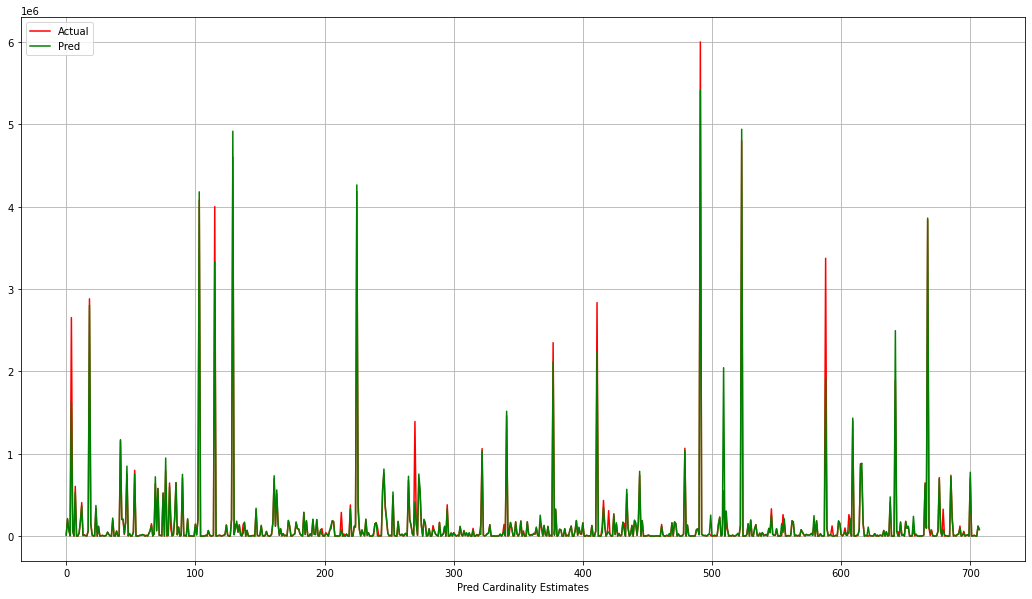

In [44]:
# ==============================================================================
#                Model 2: MLP
# ==============================================================================


import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[19]),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1,  activation='relu'),
])

model.summary()

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.007,
#    decay_steps=10000,
#    decay_rate=0.15)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="mean_squared_logarithmic_error", optimizer=optimizer)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
training_history = model.fit(X_train, y_train[:, -1], epochs=500, 
                             callbacks=[early_stop], validation_data=(X_val, y_val[:, -1]))

y_pred = np.squeeze(model.predict(X_test))
model.evaluate(X_test, y_test[:, -1])
plot_model_statistics(y_test[:, -1], y_pred)